# Obesity prediction using Machine Learning 

# Import Libraries 

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
np.random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
import joblib
from joblib import dump, load
import os
import pickle
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier # Boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier   # Stacking
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px


In [21]:
#read csv file 
df= pd.read_csv('modified_data.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Classes
0,Female,21.0,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,24.39,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,24.24,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,23.77,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,26.85,Overweight
4,Male,22.0,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,28.34,Overweight


In [22]:
df=df.drop(columns=['Height','Weight'], axis=1)

In [23]:
df.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Classes
0,Female,21.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,24.39,Normal_Weight
1,Female,21.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,24.24,Normal_Weight
2,Male,23.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,23.77,Normal_Weight
3,Male,27.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,26.85,Overweight
4,Male,22.0,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,28.34,Overweight


In [24]:
#create x and y 
features=df.drop('Classes',axis=1)
target=df['Classes']

# Data Preprocessing

In [25]:
#Create a pipline 
s = StandardScaler()
ohe = OneHotEncoder()
cat_features = features.select_dtypes('object').columns.tolist()

# Remove CALC and CAEC from the cat_features since they'll be ordinal encoded
for feature in ['CALC', 'CAEC']:
    if feature in cat_features:
        cat_features.remove(feature)

no_change_features = ['NCP','FCVC', 'CH2O', 'TUE','FAF']
num_features = ['Age','BMI']
num_transformer = Pipeline(steps=[
    ('scaling', s)
])
cat_transformer = Pipeline(steps=[
    ('onehot', ohe)
])
# Ordinal transformer
calc_order = ['no', 'Sometimes', 'Frequently','Always']
caec_order = ['no', 'Sometimes', 'Frequently','Always']
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[calc_order, caec_order]))
])
# Updated ColumnTransformer to include the ordinal transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),  # other categorical features
        ('ordinal', ordinal_transformer, ['CALC', 'CAEC']),
        ('pass_through', 'passthrough', no_change_features)
    ])
# Full pipeline: preprocessing + model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])



In [26]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling',
                                                  StandardScaler())]),
                                 ['Age', 'BMI']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always'],
                                                                             ['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']]))]),
                                 ['CALC', 'CAEC']),
                                ('pass_through', 'passthrough',
                                 ['NCP', 'FCVC', 'CH2O', 'TUE', 'FAF'])])

In [27]:
#split the data

features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)
#Fit and transform the data
X_transformed = preprocessor.fit_transform(features_train)

#Extract feature names
feature_names = []

# For one-hot encoded features
for transformer_name, transformer, columns in preprocessor.transformers_:
    if transformer_name == 'cat':
        # Get one-hot feature names
        feature_names.extend(list(transformer.named_steps['onehot'].get_feature_names_out(columns)))

    elif transformer_name == 'ordinal':
        feature_names.extend(columns)  

    elif transformer_name == 'pass_through' or transformer_name == 'num':
        feature_names.extend(columns)  

#Convert to DataFrame
transformed_df = pd.DataFrame(X_transformed, columns=feature_names)


# Ordinal encode the target_train
order = [['Insufficient_Weight', 'Normal_Weight', 'Overweight', 
          'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']]
encoder = OrdinalEncoder(categories=order)
y_encoded = encoder.fit_transform(target_train.values.reshape(-1, 1))

# Convert y_encoded to DataFrame and reset its index to match transformed_df
y_df = pd.DataFrame(y_encoded, columns=['Classes'])
y_df.reset_index(drop=True, inplace=True)

# Reset index of transformed_df to ensure the concatenation goes smoothly
transformed_df.reset_index(drop=True, inplace=True)

# Add the encoded Classes column to the transformed dataframe
transformed_df['Classes'] = y_df

transformed_df.head()



,Age,BMI,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,...,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC,NCP,FCVC,CH2O,TUE,FAF,Classes
0,-0.701820,-1.446416,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,0.0
1,0.289064,1.458557,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,5.0
2,-0.117564,-0.476434,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0
3,0.208967,0.548266,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,3.0,2.0,3.0,0.0,1.0,3.0
4,-0.190323,-0.945259,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0


In [28]:

correlation_matrix = transformed_df.corr()
correlation_matrix


,Age,BMI,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,...,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC,NCP,FCVC,CH2O,TUE,FAF,Classes
Age,1.000000,0.244884,-0.039534,0.039534,-0.195730,0.195730,-0.050599,0.050599,-0.098182,0.098182,...,-0.537855,-0.057946,0.046196,-0.083200,-0.014911,0.011738,-0.026180,-0.218639,-0.140833,0.252863
BMI,0.244884,1.000000,0.051973,-0.051973,-0.473437,0.473437,-0.246277,0.246277,0.002479,-0.002479,...,0.090476,-0.127654,0.164370,-0.310090,0.128085,0.217483,0.120781,-0.283334,-0.192314,0.982409
Gender_Female,-0.039534,0.051973,1.000000,-1.000000,0.097960,-0.097960,0.074742,-0.074742,0.051767,-0.051767,...,0.152076,-0.045822,0.005772,0.084356,-0.032097,0.262753,-0.086647,-0.092718,-0.153718,0.053453
Gender_Male,0.039534,-0.051973,-1.000000,1.000000,-0.097960,0.097960,-0.074742,0.074742,-0.051767,0.051767,...,-0.152076,0.045822,-0.005772,-0.084356,0.032097,-0.262753,0.086647,0.092718,0.153718,-0.053453
family_history_with_overweight_no,-0.195730,-0.473437,0.097960,-0.097960,1.000000,-1.000000,0.205826,-0.205826,0.011751,-0.011751,...,0.062504,0.046081,0.044594,0.168040,-0.098022,-0.025996,-0.139575,0.063059,0.062233,-0.470234
family_history_with_overweight_yes,0.195730,0.473437,-0.097960,0.097960,-1.000000,1.000000,-0.205826,0.205826,-0.011751,0.011751,...,-0.062504,-0.046081,-0.044594,-0.168040,0.098022,0.025996,0.139575,-0.063059,-0.062233,0.470234
FAVC_no,-0.050599,-0.246277,0.074742,-0.074742,0.205826,-0.205826,1.000000,-1.000000,-0.064679,0.064679,...,-0.036181,0.175924,-0.077622,0.162583,-0.018450,0.059983,-0.007200,-0.004968,0.112826,-0.259017
FAVC_yes,0.050599,0.246277,-0.074742,0.074742,-0.205826,0.205826,-1.000000,1.000000,0.064679,-0.064679,...,0.036181,-0.175924,0.077622,-0.162583,0.018450,-0.059983,0.007200,0.004968,-0.112826,0.259017
SMOKE_no,-0.098182,0.002479,0.051767,-0.051767,0.011751,-0.011751,-0.064679,0.064679,1.000000,-1.000000,...,0.019361,-0.018727,-0.079496,-0.046143,-0.005250,-0.012937,0.037060,-0.054882,0.002607,-0.004974
SMOKE_yes,0.098182,-0.002479,-0.051767,0.051767,-0.011751,0.011751,0.064679,-0.064679,-1.000000,1.000000,...,-0.019361,0.018727,0.079496,0.046143,0.005250,0.012937,-0.037060,0.054882,-0.002607,0.004974


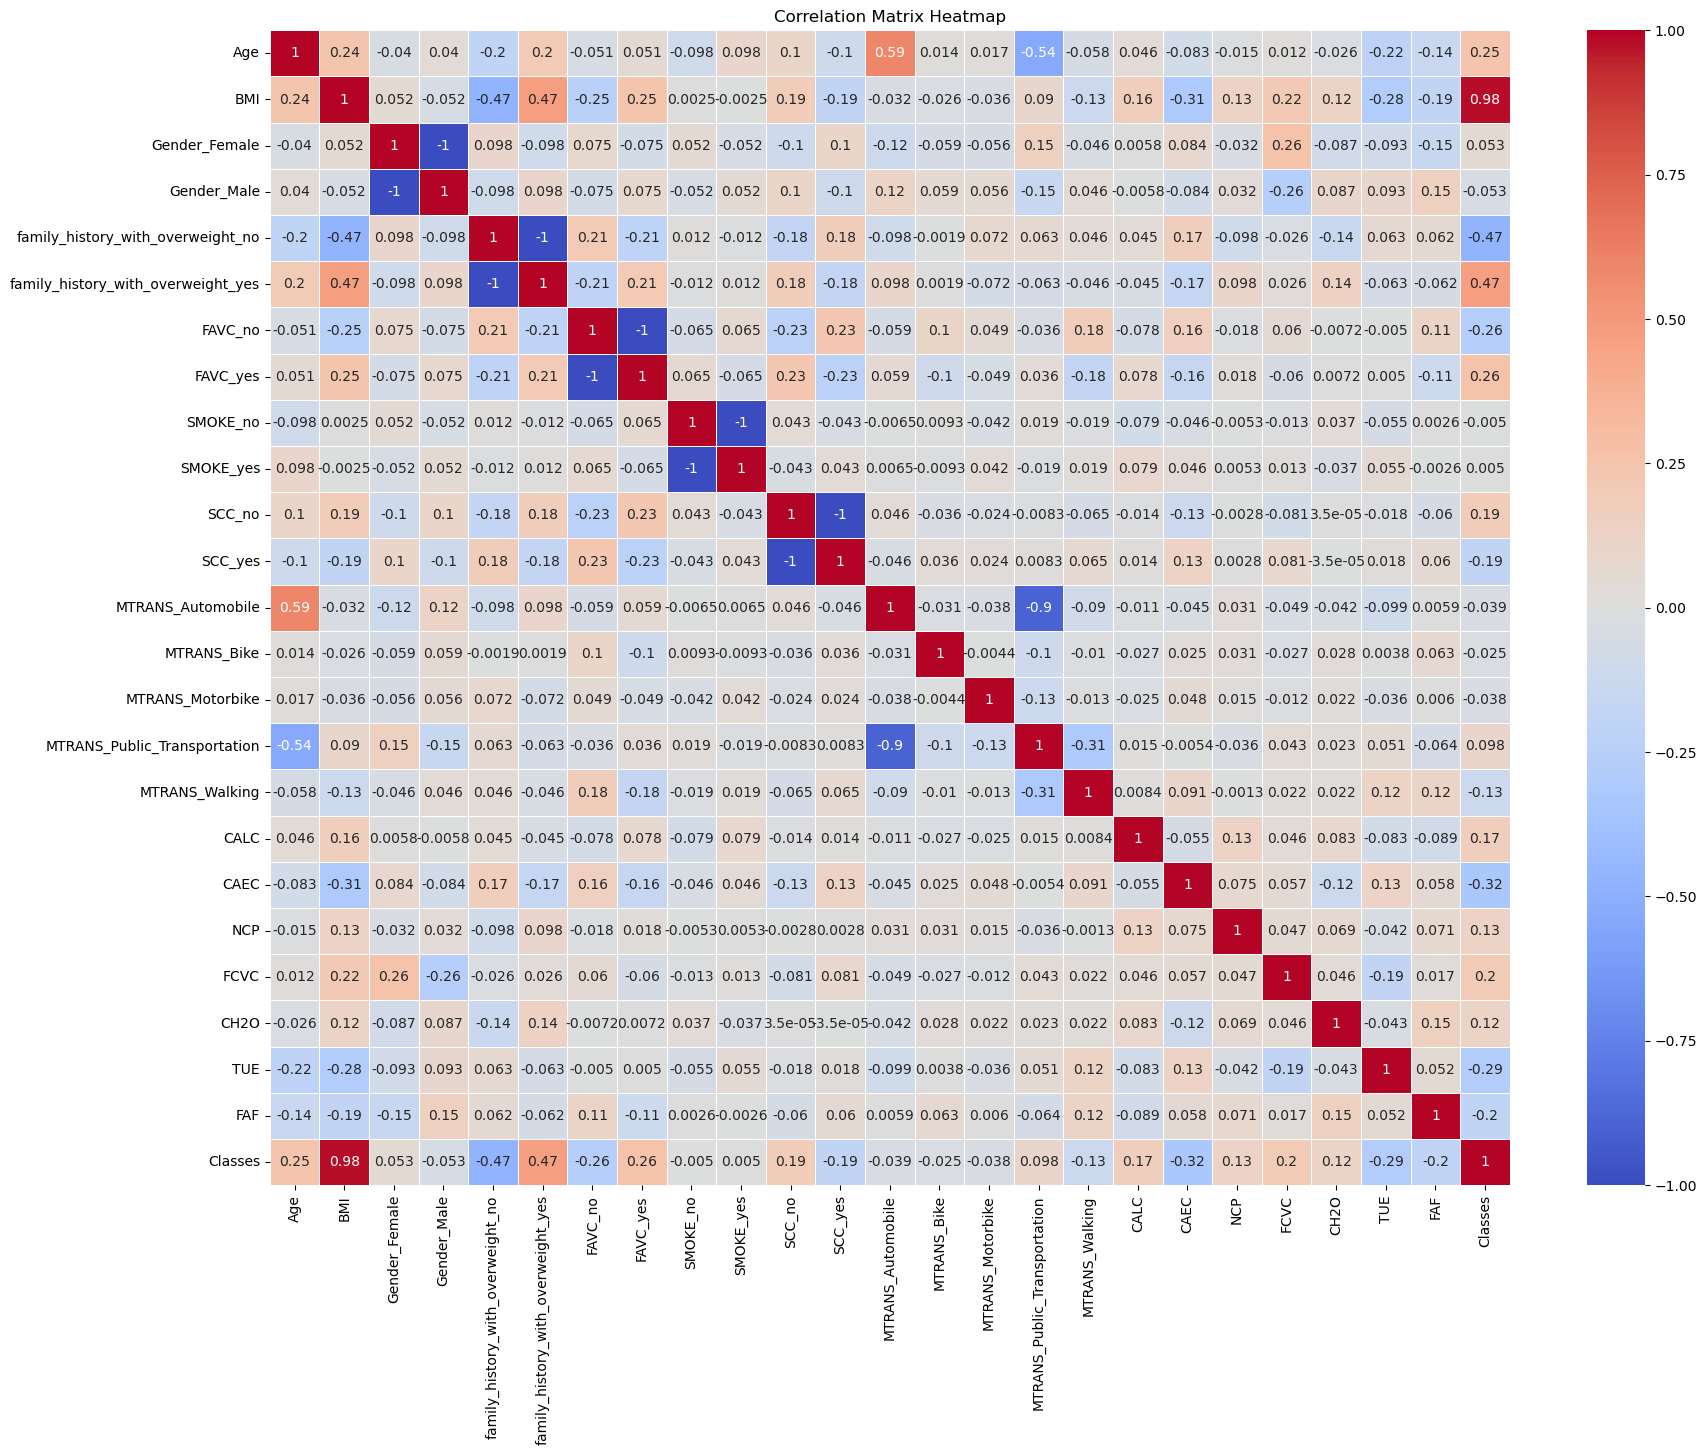

In [29]:
#plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [30]:
# multicollinearity
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

vif = calculate_vif(transformed_df)
print(vif)
while vif["VIF"].max() > 10:
    remove = vif.sort_values("VIF", ascending=False).iloc[0]
    if remove["Feature"] in df.columns:
        df.drop(remove["Feature"], axis=1, inplace=True)
        vif = calculate_vif(transformed_df)
    else:
        print(f"Column {remove['Feature']} not found in dataframe.")
        break

                               Feature        VIF
0                                  Age   1.877125
1                                  BMI  29.498766
2                        Gender_Female        inf
3                          Gender_Male        inf
4    family_history_with_overweight_no        inf
5   family_history_with_overweight_yes        inf
6                              FAVC_no        inf
7                             FAVC_yes        inf
8                             SMOKE_no        inf
9                            SMOKE_yes        inf
10                              SCC_no        inf
11                             SCC_yes        inf
12                   MTRANS_Automobile        inf
13                         MTRANS_Bike        inf
14                    MTRANS_Motorbike        inf
15        MTRANS_Public_Transportation        inf
16                      MTRANS_Walking        inf
17                                CALC   1.097242
18                                CAEC   1.197486


In [31]:


X=transformed_df.drop('Classes',axis=1)
y=transformed_df['Classes']
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]





# Create a DataFrame for the feature importances
feature_imp_df = pd.DataFrame({
    'Features': X_train.columns[indices],
    'Importance': importances[indices]
})

# Create the plotly bar chart
fig = px.bar(feature_imp_df, 
             x='Importance', 
             y='Features', 
             orientation='h', 
             title="Feature Importances",
             labels={'Importance': 'Importance Score', 'Features': 'Features'},
             template="plotly_white")

# Show the figure
fig.show()



In [32]:
#split the data
features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)

def ml_preprocess(df):
    
    features = df.drop('Classes',axis=1)
    target=df['Classes']
    return features, target


In [33]:
features, target = ml_preprocess(df)


# Machine Learning Models

# **Logistic Regression**

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. 

In [34]:
#Since the label is 6 classes so its multinomial 
lr = LogisticRegression(multi_class='multinomial', max_iter=1000)

model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', lr)
])


In [35]:
model_pipeline_lr.fit(features, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CALC', 'CAEC']),
                                                 ('pass_through', 'passthrough',
                                                  ['NCP', 'FCVC', 'CH2O', 'TUE',
                                                   'FAF'])])),
                ('clf',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

***Hyperparemeter tunning*** 

In [36]:
# Iterate over the C values as hyperparameters for regularization strength in logistic regression
for C_value in [0.1, 1, 10, 100, 1000]:
    
    model_pipeline_lr.set_params(clf__C=C_value)  # Setting the C value for the Logistic Regression in the pipeline
    
    model_pipeline_lr.fit(features_train, target_train)
    
    predicted_train = model_pipeline_lr.predict(features_train)
    predicted_test = model_pipeline_lr.predict(features_test)
    
    print('C Value', C_value)
    
    # Accuracy for training set
    train_accuracy = accuracy_score(target_train, predicted_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    
    # Accuracy for test set
    test_accuracy = accuracy_score(target_test, predicted_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report for test set
    print(classification_report(target_test, predicted_test))
    print('------------------------------------------------')


C Value 0.1
Train Accuracy: 0.8353
Test Accuracy: 0.8180
                     precision    recall  f1-score   support

Insufficient_Weight       0.84      0.94      0.89        54
      Normal_Weight       0.82      0.55      0.66        60
     Obesity_Type_I       0.85      0.69      0.76        74
    Obesity_Type_II       0.84      0.87      0.86        68
   Obesity_Type_III       0.86      0.94      0.90        54
         Overweight       0.76      0.89      0.82       113

           accuracy                           0.82       423
          macro avg       0.83      0.81      0.81       423
       weighted avg       0.82      0.82      0.81       423

------------------------------------------------
C Value 1
Train Accuracy: 0.9177
Test Accuracy: 0.9054
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.94      0.94        54
      Normal_Weight       0.93      0.83      0.88        60
     Obesity_Type_I       0.90      0.89  

In [37]:
features_train, features_test, target_train,target_test= train_test_split(features, target, test_size=0.2, random_state=42)
# Define the path to your model
model_path = "logistic_regression_model2.pkl"

# Check if the model file exists
if os.path.exists(model_path):
    # Load the model
    with open(model_path, 'rb') as file:
        model_pipeline_lr = pickle.load(file)
    print("Model loaded successfully!")

else:
     # Train the model if it doesn't exist
    model_pipeline_lr.fit(features_train, target_train)

    # Save the trained model
    with open(model_path, 'wb') as file:
        pickle.dump(model_pipeline_lr, file)
        print("Model trained and saved successfully!")

# Predict on training data to get training accuracy
train_predictions = model_pipeline_lr.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Predict on test data to get test accuracy
predicted_targets = model_pipeline_lr.predict(features_test)
test_accuracy_lr = accuracy_score(target_test, predicted_targets)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get the classification report
report = classification_report(target_test, predicted_targets)
print("Classification Report:")
print(report)


Model loaded successfully!
Training Accuracy: 99.94%
Test Accuracy: 98.11%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.98      0.94        54
      Normal_Weight       0.98      0.90      0.94        67
     Obesity_Type_I       0.97      1.00      0.98        83
    Obesity_Type_II       0.98      0.95      0.97        60
   Obesity_Type_III       1.00      0.98      0.99        58
         Overweight       0.99      1.00      1.00       101

           accuracy                           0.97       423
          macro avg       0.97      0.97      0.97       423
       weighted avg       0.97      0.97      0.97       423

